In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/dataset/'
# path

In [ ]:
_path = '/content/drive/MyDrive/movie-recommendation-dataset/'
#K's path

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
#Graphical representation imports

In [ ]:
import os
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import csr_matrix

In [ ]:
!pip install scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import accuracy
from surprise import SVD
from surprise import SVDpp

# Reading and Storing Data


In [ ]:
movies = pd.read_csv(f'{path}movie_titles.csv')

In [ ]:
files = [f'{path}combined_data_1.csv', f'{path}combined_data_2.csv', f'{path}combined_data_3.csv', f'{path}combined_data_4.csv']

In [ ]:
# Create a new dataframe to contain all data in the files

data = pd.read_csv(f'{path}data.csv', names=['MovieID', 'CustID', 'Rating', 'Date'])

In [ ]:
data.tail()

In [ ]:
# Save data

def save_data(df):
  result = pd.concat([data, df.iloc[1:]])
  result.to_csv(f'{path}data.csv', index=False)

In [ ]:
df1 = pd.read_csv(files[0], names=['CustID', 'Rating', 'Date'])
movieID = df1['CustID'][0]
df1.insert(0, "MovieID", movieID[:len(movieID) - 1])


In [ ]:
df1 = pd.read_csv(files[0], names=['CustID', 'Rating', 'Date'])

In [ ]:
df1.head()

In [ ]:
def create_dataset():
  if not os.path.isfile(f'{path}data.csv'):
    data = open(f'{path}data.csv', mode='w')

    row = list()
    for file in files:
        with open(file) as f:
            for line in f:
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()

In [ ]:
create_dataset()

In [ ]:
df2 = pd.read_csv(files[1], names=['CustID', 'Rating', 'Date'])
movieID = df2['CustID'][0]
df2.insert(0, "MovieID", movieID[:len(movieID) - 1])

In [ ]:
df3 = pd.read_csv(files[2], names=['CustID', 'Rating', 'Date'])
movieID = df3['CustID'][0]
df3.insert(0, "MovieID", movieID[:len(movieID) - 1])

In [ ]:
df4 = pd.read_csv(files[3], names=['CustID', 'Rating', 'Date'])
movieID = df4['CustID'][0]
df4.insert(0, "MovieID", movieID[:len(movieID) - 1])

In [ ]:
# save_data(df4)

In [ ]:
data['Date'] = pd.to_datetime(data["Date"])
data.sort_values(by="Date", inplace=True)

In [ ]:
data.to_csv(f'{path}data.csv', index=False)

In [ ]:
data.head()

In [ ]:
df2.head()

In [ ]:
movies.drop(["others", "more", "prefix"], axis=1, inplace=True)

In [ ]:
movies.head()


# Performing Exploratory Data Analysis on Data

### Dividing dataset into train and test data

In [ ]:
train_data = pd.read_csv(f'{path}train.csv')
test_data = pd.read_csv(f'{path}test.csv')

In [ ]:
def dataset_train_test_split(dataset):
  if not os.path.isfile(f'{path}train.csv'):
    dataset.iloc[:int(dataset.shape[0]*0.80)].to_csv(f"{path}train.csv", index=False)

  if not os.path.isfile(f'{path}test.csv'):
    dataset.iloc[int(dataset.shape[0]*0.80):].to_csv(f"{path}test.csv", index=False)

In [ ]:
dataset_train_test_split(data)

In [ ]:
test_data.head()

# Creating User-Item sparse matrix for the data

In [ ]:
def is_file_available(file_name: str, path: str):
    if os.path.isfile(f'{path}{file_name}'):
        return True
    else:
        return False

def create_sparse_matrix(dataset_type: str, dataset = dict()):
    if is_file_available(f'{dataset_type}_sparse_matrix.npz', path):
        print('reading file')
        sparse_matrix = sparse.load_npz(f'{path}{dataset_type}_sparse_matrix.npz')
        return sparse_matrix
    else:
        sparse_matrix = sparse.csr_matrix((dataset.Rating.values, (dataset.CustID.values,
                                                dataset.MovieID.values)),)
        sparse.save_npz(f"{path}{dataset_type}_sparse_matrix.npz", sparse_matrix)
        return sparse_matrix

In [ ]:
train_sparse_matix = create_sparse_matrix("train", train_data.iloc[:int(train_data.shape[0]*0.50)])

In [ ]:
train_sparse_matix = create_sparse_matrix("train")

In [ ]:
train_sparse_matix = sparse.csr_matrix((train_data.Rating.values, (train_data.CustID.values, train_data.MovieID.values)),)
test_sparse_matix = sparse.csr_matrix((test_data.Rating.values, (test_data.CustID.values, test_data.MovieID.values)),)

### Checking if movie to movie similarity works

#### Creating movie to movie similarity matrix

In [ ]:
def create_movie_to_movie_similarity_matrix(sparse_matrix, dataset_type: str):
    if is_file_available(f'{path}{dataset_type}_m_m_sim_sparse.npz', path):
        similarity_matrix = cosine_similarity(X=sparse_matrix.T, dense_output=False)
        sparse.save_npz(f'{path}{dataset_type}_m_m_sim_sparse.npz', similarity_matrix)
        return similarity_matrix

    else:
        similarity_matrix = sparse.load_npz(f'{path}{dataset_type}_m_m_sim_sparse.npz')
        return similarity_matrix

In [ ]:
# creating movie to movie similarity matrix for training data

train_similarity_matrix = cosine_similarity(X = train_sparse_matix.T, dense_output = False)

In [ ]:
def find_similar_movies(m_m_sim_sparse):
    movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])
    similar_movies = dict()
    for movie in movie_ids:
        sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
        similar_movies[movie] = sim_movies[:100]

    return similar_movies

In [ ]:
find_similar_movies(train_similarity_matrix)

Creating user to user similarity matrix

In [ ]:
def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100):
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind))
    time_taken = list()

    rows, cols, data = list(), list(), list()
    temp = 0

    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

In [ ]:
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100)

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path):
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )

    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    sparse.save_npz(path, sample_sparse_matrix)

    return sample_sparse_matrix

In [ ]:
sparse_matrix = sparse.load_npz(f"{path}train_sparse_matrix.npz")

In [ ]:
users, movies, ratings = sparse.find(sparse_matrix)

In [ ]:
def calculate_average_ratings(sparse_matrix, for_users):
    axis = 1 if for_users else 0
    sum_of_ratings = sparse_matrix.sum(axis=axis).A1
    is_rated = sparse_matrix != 0
    num_ratings = is_rated.sum(axis=axis).A1

    num_rows, num_cols = sparse_matrix.shape
    averages = {i: sum_of_ratings[i] / num_ratings[i]
                for i in range(num_rows if for_users else num_cols)
                if num_ratings[i] != 0}

    return averages


In [ ]:
sample_train_averages = dict()
global_average = sparse_matrix.sum()/sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average

In [ ]:
sample_train_averages['user'] = get_average_ratings(sparse_matrix, of_users=True)

In [ ]:
sample_train_averages['movie'] =  get_average_ratings(sparse_matrix, of_users=False)

In [ ]:
def featurize_data(sparse_matrix):
    if os.path.isfile(f'{path}featurized_dataset.csv'):
        print("File already exists you don't have to prepare again..." )
    else:
        with open(f'{path}featurized_dataset.csv', mode='w') as reg_data_file:
            count = 0
            for (user, movie, rating)  in zip(users, movies, ratings):

                # For similar users
                user_sim = cosine_similarity(sparse_matrix[user], sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:]
                top_ratings = sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

                movie_sim = cosine_similarity(sparse_matrix[:,movie].T, sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:]

                top_ratings = sparse_matrix[user, top_sim_movies].toarray().ravel()

                # For similar movies
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
                row = list()
                row.append(user)
                row.append(movie)
                row.append(sample_train_averages['global'])
                row.extend(top_sim_users_ratings)

                row.extend(top_sim_movies_ratings)

                row.append(sample_train_averages['user'][user])

                row.append(sample_train_averages['movie'][movie])

                row.append(rating)
                count = count + 1

                reg_data_file.write(','.join(map(str, row)))
                reg_data_file.write('\n')

In [ ]:
featurize_data(sparse_matrix)

#Graphical representation

In [ ]:
movies = pd.read_csv(f'{_path}movie_titles.csv')

In [ ]:
_files = [f'{_path}combined_data_1.csv', f'{_path}combined_data_2.csv', f'{_path}combined_data_3.csv', f'{_path}combined_data_4.csv']

In [ ]:
_data = pd.read_csv(f'{_path}data.csv')

In [ ]:
_data.head()

,MovieID,CustID,Rating,Date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


**Distribution of Ratings over Training Dataset**

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/movie-recommendation-dataset/train.csv')

**Analysis of Rating per Movie**

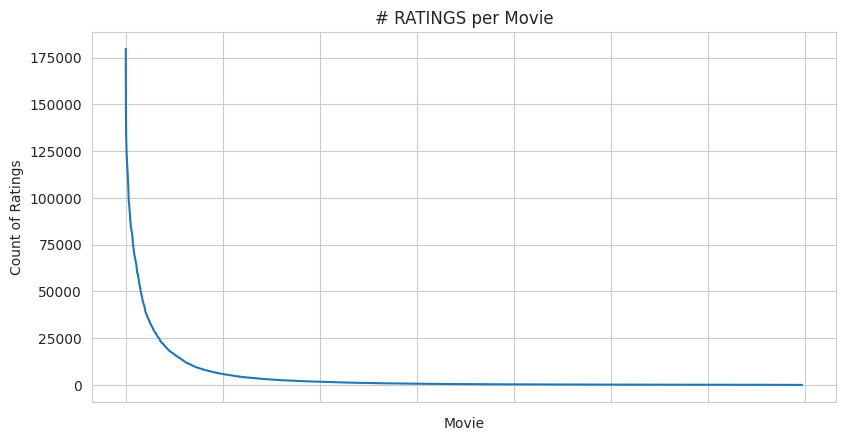

In [ ]:
no_of_ratings_per_movie = train_data.groupby(by='MovieID')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('Count of Ratings')
ax.set_xticklabels([])

plt.show()


Human Function

In [ ]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<ipython-input-21-0fa50e7bfafa>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in tick_positions])


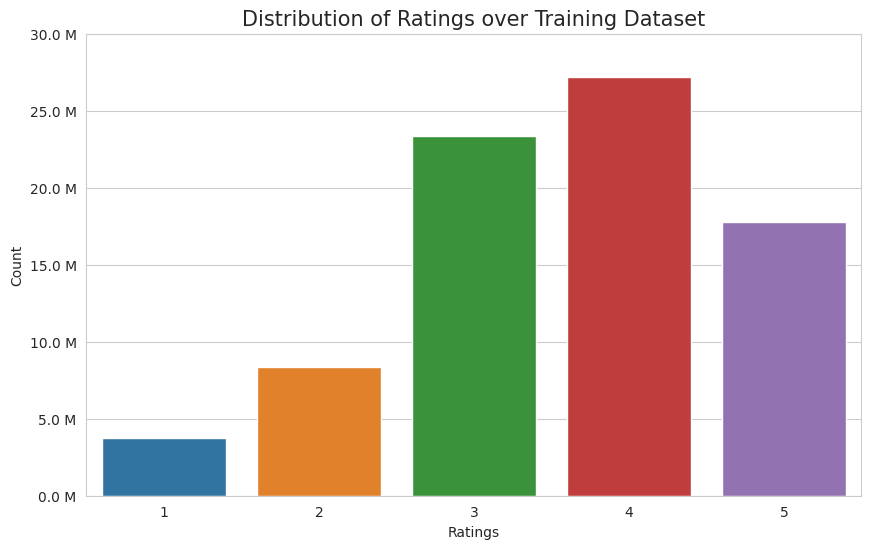

In [ ]:

sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=train_data, x='Rating', ax=ax)

tick_positions = ax.get_yticks()
ax.set_yticklabels([human(item, 'M') for item in tick_positions])
ax.yaxis.set_major_locator(plt.FixedLocator(tick_positions))
ax.set_yticks(tick_positions)
plt.title('Distribution of Ratings over Training Dataset', fontsize=15)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

#Featurization

In [ ]:
final_data = pd.read_csv('/content/drive/MyDrive/movie-recommendation-dataset/featurized_dataset.csv', names =['user',	'movie',	'GAvg',	'sur1',	'sur2',	'sur3',	'sur4',	'sur5',	'smr1',	'smr2',	'smr3',	'smr4',	'smr5',	'UAvg',	'MAvg',	'rating'])

# GAvg : Average rating of all the ratings

# Similar users rating of this movie:

# sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
# Similar movies rated by this user:

# smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this user.. )
# UAvg : User's Average rating

# MAvg : Average rating of this movie

# rating : Rating of this movie by this user.

In [ ]:
final_data.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,6,241,3.689887,3,4,4,4,4,4.0,3.0,2.0,4.0,3.0,3.194737,4.142783,3
1,6,468,3.689887,5,3,5,5,5,4.0,5.0,5.0,2.0,5.0,3.194737,3.743761,3
2,6,501,3.689887,4,4,3,4,3,4.0,3.0,3.0,4.0,3.0,3.194737,3.808137,3
3,6,528,3.689887,2,3,3,4,4,3.0,3.0,3.0,4.0,3.0,3.194737,2.954018,4
4,6,658,3.689887,4,3,5,4,4,3.0,3.0,3.0,2.0,4.0,3.194737,3.691386,3


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error


#Splitting into train and test set

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'rating' is the target variable
X = final_data.drop('rating', axis=1)  # Features (everything except 'rating')
y = final_data['rating']  # Target variable

# Split the data into a training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (5458, 15) (5458,)
Test set shape: (1365, 15) (1365,)


#Modelling Data

**XGBoost**

In [ ]:
X = final_data.drop('rating', axis=1)  # Features (everything except 'rating')
y = final_data['rating']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.8683893193667906


In [ ]:
# Assuming 'user', 'movie', and 'rating' are the columns in your dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_data[['user', 'movie', 'rating']], reader)


**Spliting into training and test sets**

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


**Surprise Baselineonly**

In [ ]:
# Instantiate the BaselineOnly algorithm
algo = BaselineOnly()

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Evaluate the model using accuracy metrics
accuracy.rmse(predictions)


Estimating biases using als...
RMSE: 0.9519


0.951891324052058

**KNNBaseline**

In [ ]:
# Instantiate the KNNBaseline algorithm
algo = KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based': False})

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Evaluate the model using accuracy metrics
accuracy.rmse(predictions)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0011


1.0010926333713321

**SVD**

In [ ]:
# Instantiate the SVD algorithm
algo = SVD()

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Evaluate the model using accuracy metrics
accuracy.rmse(predictions)

RMSE: 0.9626


0.9626209058901297

**SVDpp**

In [ ]:
# Instantiate the SVD++ algorithm
algo = SVDpp()

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Evaluate the model using accuracy metrics
accuracy.rmse(predictions)

RMSE: 0.9618


0.9618406755668829